In [1]:
# Installation des dépendances nécessaires
!pip install -q imbalanced-learn xgboost

# 🌍 Mini-projet 6 : Classification de la stabilité des terrains (Risque de glissement)

## 👥 Membres du Groupe
Ce projet a été réalisé en collaboration par :
- **Mohamed Driouch**
- **Youness Roubai**
- **Marouane Bakali**
- **COULIBALY Cheickna Hamala**

## 📌 Description du Projet
Ce projet s'inscrit dans le cadre de notre cours d'Apprentissage Supervisé. L'objectif principal est de mettre en œuvre un processus complet de Machine Learning pour classifier des zones géographiques selon leur niveau de stabilité, afin d'identifier les zones à risque de glissement de terrain.

## 📊 Données
Le modèle est entraîné sur le dataset `geo_stabilite_terrain_data.csv`. Les variables explicatives incluent des données topographiques (pente, altitude), géologiques (texture du sol, distance aux failles, indice géotechnique) et environnementales (humidité, couverture végétale).
- **Variable Cible :** `stabilite_terrain` (Classes : *stable, moyennement stable, instable*).

## ⚙️ Modélisation et Modèles Évalués
Afin de trouver la meilleure solution de classification et de comparer les performances, nous avons implémenté et optimisé les modèles de Machine Learning suivants :
1. **XGBoost Classifier** (Extreme Gradient Boosting)
2. **CatBoost Classifier**
3. **LightGBM** (Light Gradient Boosting Machine)
4. **Random Forest Classifier**
5. **Support Vector Machine (SVM)**

## 🚀 Étapes Principales du Projet
- **Analyse Exploratoire des Données (EDA) :** Visualisation des distributions, analyse des valeurs manquantes et cartographie spatiale.
- **Prétraitement :** Nettoyage des données, traitement des valeurs manquantes, encodage des variables catégorielles et standardisation.
- **Modélisation :** Séparation des données (Train/Test) et entraînement des différents modèles.
- **Optimisation :** Recherche des meilleurs hyperparamètres pour maximiser les performances.
- **Évaluation :** Comparaison des modèles via la Matrice de confusion, l'Accuracy, la Précision, le Recall et le F1-score.

---
## 1. Import des bibliothèques

In [2]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE

# Paramètres d'affichage 
sns.set_theme(style='whitegrid', palette='muted')
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:.3f}'.format)
print(' Bibliothèques importées avec succès.')


 Bibliothèques importées avec succès.


---
## 2. Chargement et première exploration des données

In [3]:
# Chargement du fichier CSV
df = pd.read_csv('geo_stabilite_terrain_data.csv')

print(f' Dimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes')
print('\n Aperçu des 5 premières lignes :')
display(df.head())

 Dimensions : 1549 lignes × 11 colonnes

 Aperçu des 5 premières lignes :


,pente_pct,altitude_m,texture_sol,humidite_sol,distance_faille_km,couverture_vegetale,longitude,latitude,zone_id,stabilite_terrain,indice_geotech_labo
0,14.982,640.305,0.488,42.207,6.767,0.708,-6.259,34.430,427,Moyennement_stable,NaN
1,38.029,845.545,0.402,26.104,0.120,0.268,-6.549,34.861,344,MOY_STABLE,NaN
2,29.280,622.540,0.154,15.356,0.988,0.205,-6.203,34.570,507,moyennement stable,NaN
3,23.946,522.707,0.573,7.113,10.581,0.527,-5.632,35.252,341,Moyennement_stable,NaN
4,6.241,622.014,0.277,34.043,NaN,0.311,-6.538,35.193,321,Moyennement_stable,NaN


In [4]:
# Informations générales : types, valeurs non-nulles
print(' Informations générales :')
df.info()
print('\n Statistiques descriptives :')
display(df.describe(include='all'))

 Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pente_pct            1455 non-null   float64
 1   altitude_m           1501 non-null   float64
 2   texture_sol          1417 non-null   float64
 3   humidite_sol         1443 non-null   float64
 4   distance_faille_km   1486 non-null   float64
 5   couverture_vegetale  1455 non-null   float64
 6   longitude            1549 non-null   float64
 7   latitude             1549 non-null   float64
 8   zone_id              1549 non-null   int64  
 9   stabilite_terrain    1548 non-null   object 
 10  indice_geotech_labo  156 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 133.2+ KB

 Statistiques descriptives :


,pente_pct,altitude_m,texture_sol,humidite_sol,distance_faille_km,couverture_vegetale,longitude,latitude,zone_id,stabilite_terrain,indice_geotech_labo
count,1455.000,1501.000,1417.000,1443.000,1486.000,1455.000,1549.000,1549.000,1549.000,1548,156.000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moyennement_stable,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,NaN
mean,19.914,608.527,0.491,24.753,5.877,0.488,-5.939,34.995,362.593,NaN,0.551
std,11.727,176.182,0.287,11.592,3.414,0.253,0.373,0.351,92.572,NaN,0.135
min,0.185,70.730,0.000,5.157,0.053,0.050,-6.600,34.400,200.000,NaN,0.172
25%,9.516,486.733,0.237,14.742,2.974,0.277,-6.264,34.689,283.000,NaN,0.466
50%,20.137,606.883,0.483,24.641,5.804,0.479,-5.934,34.979,362.000,NaN,0.539
75%,29.992,724.725,0.739,34.700,8.769,0.698,-5.616,35.309,442.000,NaN,0.637


> Interprétation : On observe le type de chaque colonne et les premières valeurs manquantes éventuelles.  
> La colonne `texture_sol` peut être numérique ou catégorielle selon la nature de l'encodage initial.
> On vérifiera cela lors du prétraitement.


3. Analyse Exploratoire des Données (EDA) - Avant prétraitement

  Valeurs manquantes détectées :


,Nb manquantes,% manquantes
indice_geotech_labo,1393,89.929
texture_sol,132,8.522
humidite_sol,106,6.843
pente_pct,94,6.068
couverture_vegetale,94,6.068
distance_faille_km,63,4.067
altitude_m,48,3.099
stabilite_terrain,1,0.065


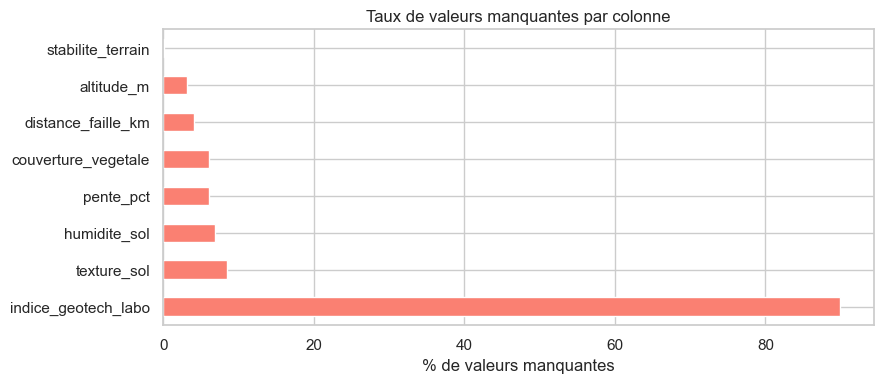

In [5]:
# 3.1 Valeurs manquantes 
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({'Nb manquantes': missing, '% manquantes': missing_pct})
missing_df = missing_df[missing_df['Nb manquantes'] > 0].sort_values('% manquantes', ascending=False)

if missing_df.empty:
    print(' Aucune valeur manquante détectée.')
else:
    print('  Valeurs manquantes détectées :')
    display(missing_df)

    # Visualisation
    fig, ax = plt.subplots(figsize=(9, 4))
    missing_df['% manquantes'].plot(kind='barh', ax=ax, color='salmon')
    ax.set_xlabel('% de valeurs manquantes')
    ax.set_title('Taux de valeurs manquantes par colonne')
    plt.tight_layout()
    plt.show()

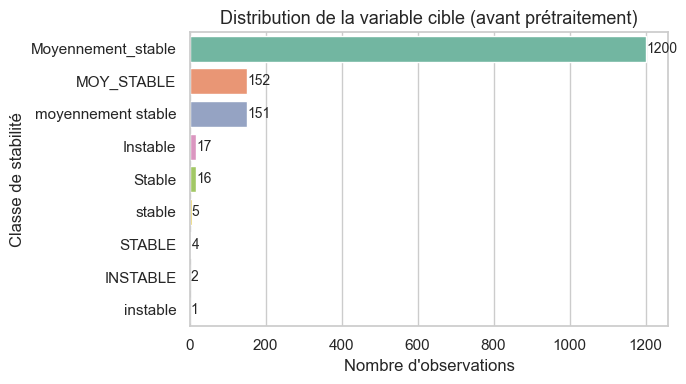

stabilite_terrain
Moyennement_stable    1200
MOY_STABLE             152
moyennement stable     151
Instable                17
Stable                  16
stable                   5
STABLE                   4
INSTABLE                 2
instable                 1
Name: count, dtype: int64


In [6]:
# 3.2 Distribution de la variable cible
fig, ax = plt.subplots(figsize=(7, 4))
order = df['stabilite_terrain'].value_counts().index
sns.countplot(data=df, y='stabilite_terrain', order=order, ax=ax, palette='Set2')
ax.set_title('Distribution de la variable cible (avant prétraitement)', fontsize=13)
ax.set_xlabel('Nombre d\'observations')
ax.set_ylabel('Classe de stabilité')
for p in ax.patches:
    ax.text(p.get_width() + 1, p.get_y() + p.get_height()/2,
            f'{int(p.get_width())}', va='center', fontsize=10)
plt.tight_layout()
plt.show()
print(df['stabilite_terrain'].value_counts())

> Interprétation : Si une classe est sur-représentée (ex. 'stable' >> 'instable'), cela constitue un déséquilibre de classes.  
> Pour y remédier, on utilisera le paramètre " class_weight='balanced' " dans le SVM, ce qui attribue un poids inversement proportionnel à la fréquence de chaque classe.

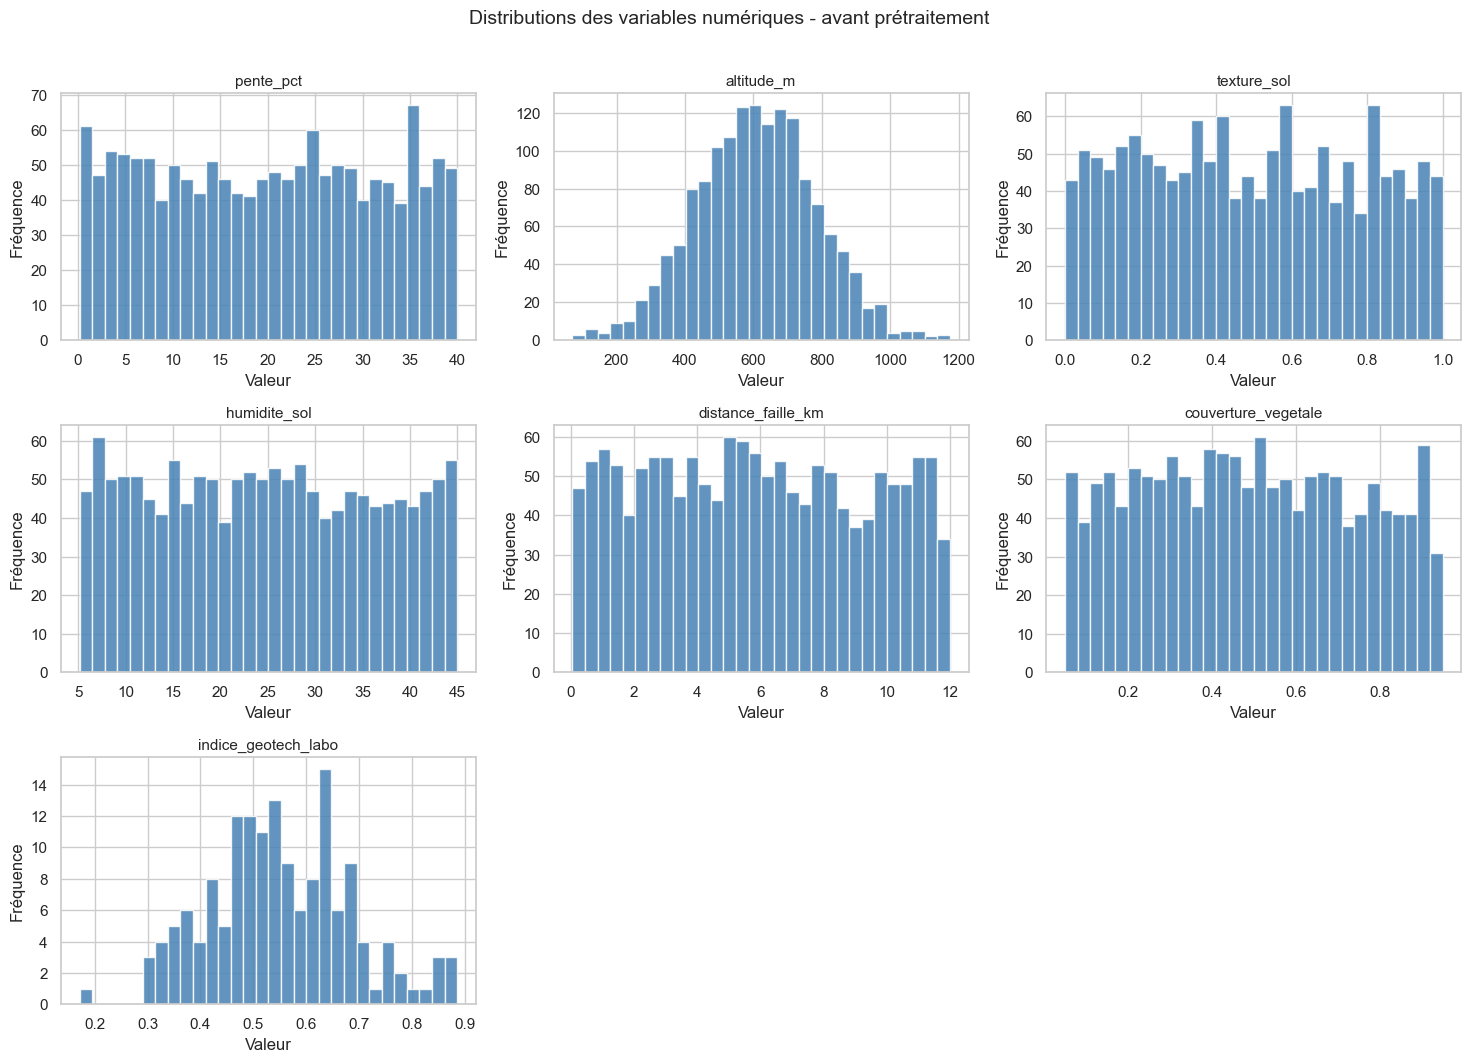

In [7]:
#3.3 Distribution des variables numériques (histogrammes) 
spatial_cols = ['latitude', 'longitude', 'zone_id']
num_cols = [c for c in df.select_dtypes(include=np.number).columns if c not in spatial_cols]

n = len(num_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3.5))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    axes[i].hist(df[col].dropna(), bins=30, color='steelblue', edgecolor='white', alpha=0.85)
    axes[i].set_title(col, fontsize=11)
    axes[i].set_xlabel('Valeur')
    axes[i].set_ylabel('Fréquence')
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
fig.suptitle('Distributions des variables numériques - avant prétraitement', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

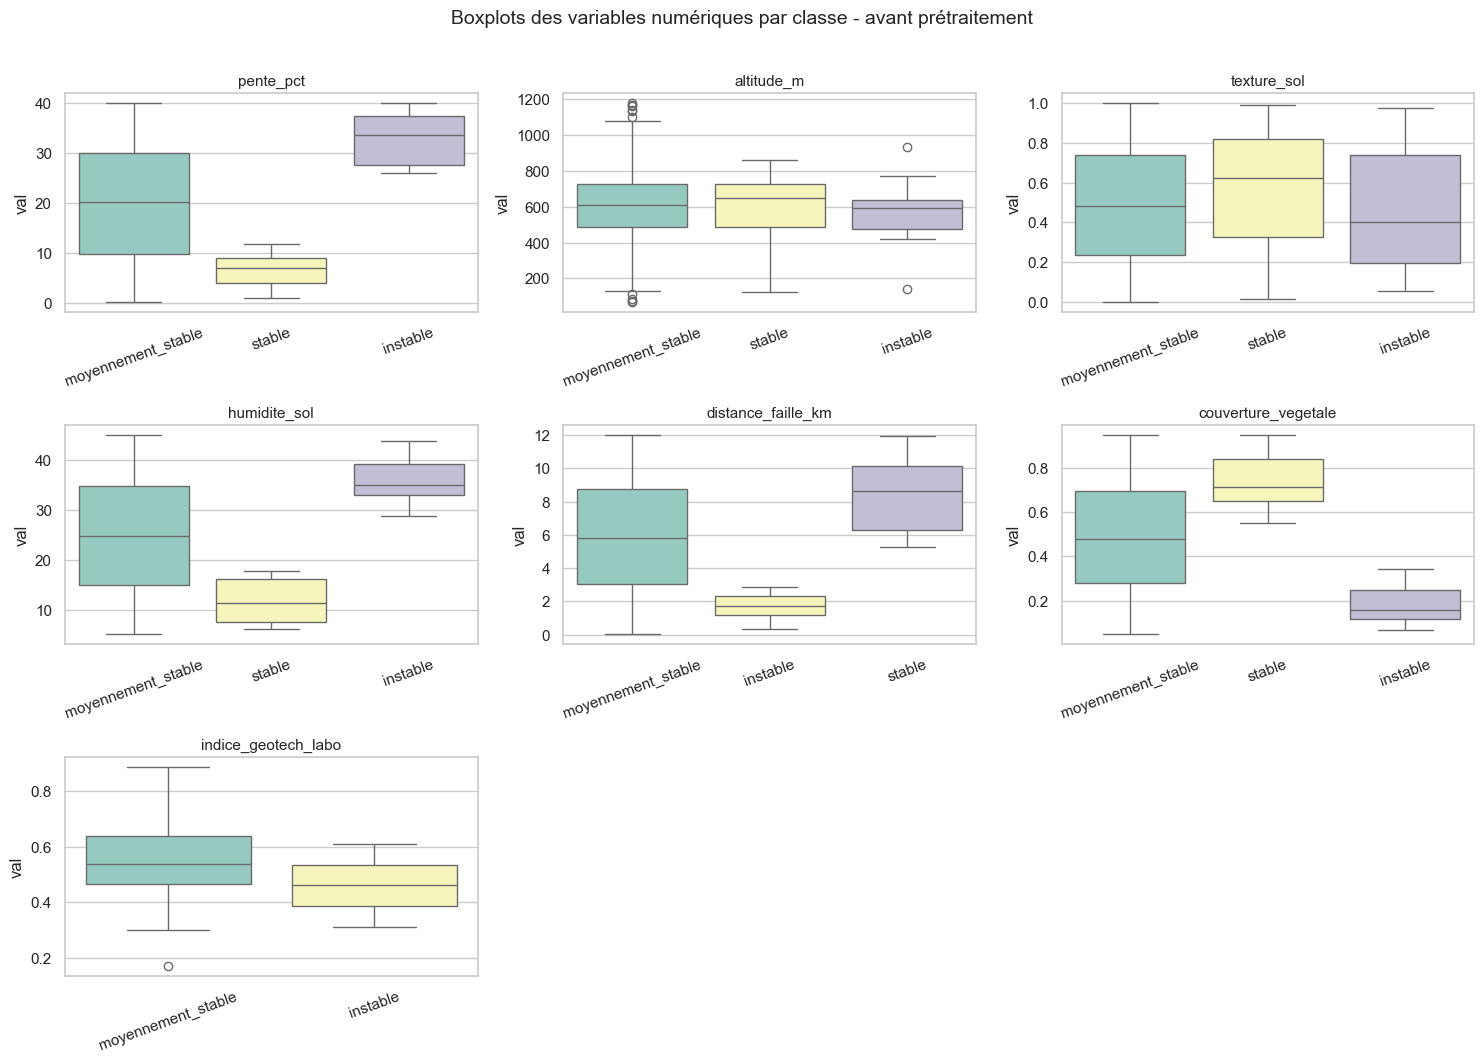

In [8]:
#  3.4 Boxplots par classe (détection d'outliers et discrimination)
target_clean_tmp = df['stabilite_terrain'].str.strip().str.lower().replace(
    {'moy_stable': 'moyennement_stable', 'moyennement stable': 'moyennement_stable'}
)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3.5))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    tmp = pd.DataFrame({'val': df[col], 'classe': target_clean_tmp}).dropna()
    sns.boxplot(data=tmp, x='classe', y='val', palette='Set3', ax=axes[i])
    axes[i].set_title(col, fontsize=11)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=20)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
fig.suptitle('Boxplots des variables numériques par classe - avant prétraitement', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

> Interprétation : Les boxplots permettent de :
> - Détecter des valeurs aberrantes (points au-delà des moustaches)
> - Évaluer la capacité discriminante de chaque variable : si les distributions diffèrent selon la classe, la variable est informative.
> - Par exemple, on s'attend à ce que `pente_pct` et `humidite_sol` soient plus élevées pour les zones instables.

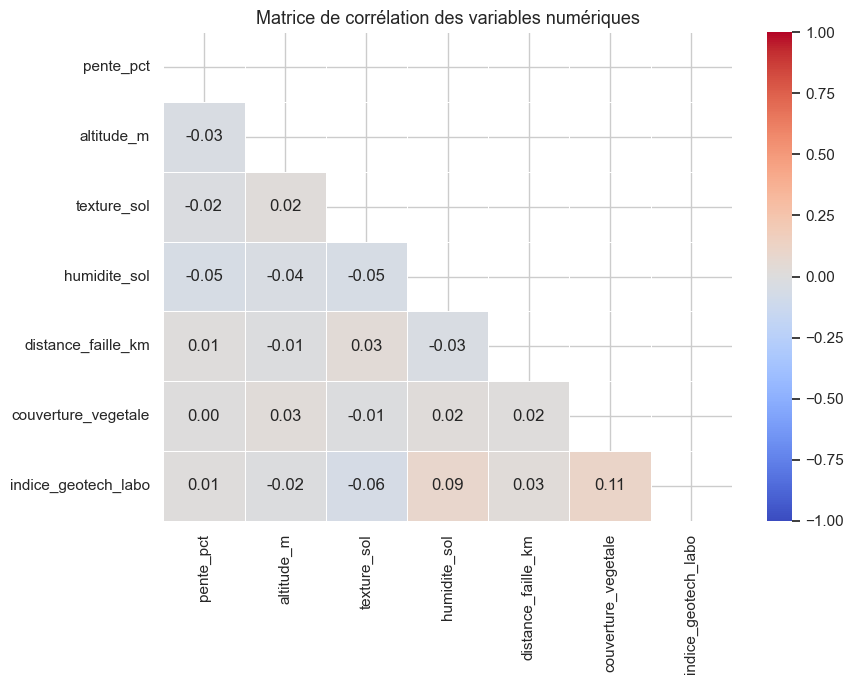

In [9]:
# 3.5 Matrice de corrélation 
corr_matrix = df[num_cols].corr()
fig, ax = plt.subplots(figsize=(9, 7))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f',
    cmap='coolwarm', center=0, vmin=-1, vmax=1,
    linewidths=0.5, ax=ax
)
ax.set_title('Matrice de corrélation des variables numériques', fontsize=13)
plt.tight_layout()
plt.show()

> Interprétation : Une corrélation forte entre deux variables explicatives (> 0.8 ou < -0.8) indique une multicolinéarité potentielle.  
> Le SVM avec noyau RBF est relativement robuste à la multicolinéarité, mais une trop grande redondance peut alourdir inutilement le modèle.

---
## 4. Prétraitement des données

In [10]:
#  4.1 Harmonisation des noms de colonnes 
df.columns = df.columns.str.strip().str.lower()
print(' Colonnes harmonisées :', df.columns.tolist())

 Colonnes harmonisées : ['pente_pct', 'altitude_m', 'texture_sol', 'humidite_sol', 'distance_faille_km', 'couverture_vegetale', 'longitude', 'latitude', 'zone_id', 'stabilite_terrain', 'indice_geotech_labo']


In [11]:
#  4.2 Nettoyage et harmonisation de la variable cible 
# les modalités peuvent avoir des espaces ou des variantes (ex. 'moy_stable' au lieu de 'moyennement_stable')
df['stabilite_terrain'] = df['stabilite_terrain'].str.strip().str.lower()
mapping_target = {
    'moy_stable'          : 'moyennement_stable',
    'moyennement stable'  : 'moyennement_stable',
    'moyennement_stable'  : 'moyennement_stable',
    'stable'              : 'stable',
    'instable'            : 'instable'
}
df['stabilite_terrain'] = df['stabilite_terrain'].replace(mapping_target)

# Suppression des lignes à cible manquante ou non reconnue
valid_classes = {'stable', 'moyennement_stable', 'instable'}
n_before = len(df)
df = df[df['stabilite_terrain'].isin(valid_classes)]
print(f' Lignes supprimées (cible invalide ou manquante) : {n_before - len(df)}')
print('Distribution après harmonisation :')
print(df['stabilite_terrain'].value_counts())

 Lignes supprimées (cible invalide ou manquante) : 1
Distribution après harmonisation :
stabilite_terrain
moyennement_stable    1503
stable                  25
instable                20
Name: count, dtype: int64


In [12]:
#  4.3 Suppression des variables spatiales. latitude, longitude et zone_id sont des identifiants spatiaux. Les inclure dans le modèle induirait un sur-apprentissage lié à la géographie plutôt qu'aux caractéristiques intrinsèques du terrain.Ils sont conservés uniquement pour les visualisations.
spatial_cols = [c for c in ['latitude', 'longitude', 'zone_id'] if c in df.columns]
df_model = df.drop(columns=spatial_cols)
print(f' Variables spatiales supprimées : {spatial_cols}')
print(f' Dimensions après suppression : {df_model.shape}')

 Variables spatiales supprimées : ['latitude', 'longitude', 'zone_id']
 Dimensions après suppression : (1548, 8)


In [13]:
# 4.4 Détection et suppression des doublons 
n_dup = df_model.duplicated().sum()
print(f' Nombre de doublons détectés : {n_dup}')
if n_dup > 0:
    df_model = df_model.drop_duplicates()
    print(f' Doublons supprimés. Nouvelles dimensions : {df_model.shape}')
else:
    print(' Aucun doublon.')

 Nombre de doublons détectés : 3
 Doublons supprimés. Nouvelles dimensions : (1545, 8)


In [14]:
#  4.5 Séparation features / cible et identification des types 
y_raw = df_model['stabilite_terrain']
X_raw = df_model.drop(columns=['stabilite_terrain'])

# Identifier colonnes numériques et catégorielles
cat_cols = X_raw.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols_model = X_raw.select_dtypes(include=np.number).columns.tolist()

print(f'Variables numériques  ({len(num_cols_model)}) : {num_cols_model}')
print(f'Variables catégorielles ({len(cat_cols)}) : {cat_cols}')

Variables numériques  (7) : ['pente_pct', 'altitude_m', 'texture_sol', 'humidite_sol', 'distance_faille_km', 'couverture_vegetale', 'indice_geotech_labo']
Variables catégorielles (0) : []


In [15]:
#  4.6 Encodage de la variable cible
# Le SVC attend des étiquettes numériques. On utilise LabelEncoder pour conserver la correspondance classe <-> code.
le = LabelEncoder()
y = le.fit_transform(y_raw)
print('Correspondance classes -> codes :')
for cls, code in zip(le.classes_, le.transform(le.classes_)):
    print(f'  {cls} -> {code}')

Correspondance classes -> codes :
  instable -> 0
  moyennement_stable -> 1
  stable -> 2


In [16]:
#  4.7 Suppression des colonnes trop manquantes (seuil 50%) 
# une colonne avec > 50 % de valeurs manquantes apporte peu d'information et toute imputation serait artificiellement dominante.

thresh = 0.5
missing_ratio = X_raw.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > thresh].index.tolist()
if cols_to_drop:
    print(f'  Colonnes supprimées (> {thresh*100:.0f}% manquants) : {cols_to_drop}')
    X_raw = X_raw.drop(columns=cols_to_drop)
    cat_cols = [c for c in cat_cols if c not in cols_to_drop]
    num_cols_model = [c for c in num_cols_model if c not in cols_to_drop]
else:
    print(' Aucune colonne supprimée pour excès de valeurs manquantes.')

  Colonnes supprimées (> 50% manquants) : ['indice_geotech_labo']


In [17]:
# 4.8 Construction du pipeline de prétraitement 
# Colonnes numériques : imputation par médiane(robuste aux valeurs aberrantes) + standardisation(SVM est sensible à l'échelle des features)
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Colonnes catégorielles : imputation + encodage ordinal
# (si texture_sol est catégorielle, ex. 'argile', 'limon', 'sable')
if cat_cols:
    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    preprocessor = ColumnTransformer([
        ('num', num_transformer, num_cols_model),
        ('cat', cat_transformer, cat_cols)
    ])
else:
    preprocessor = ColumnTransformer([
        ('num', num_transformer, num_cols_model)
    ])

print(' Pipeline de prétraitement construit.')
print(f'   Colonnes numériques : {num_cols_model}')
print(f'   Colonnes catégorielles : {cat_cols}')

 Pipeline de prétraitement construit.
   Colonnes numériques : ['pente_pct', 'altitude_m', 'texture_sol', 'humidite_sol', 'distance_faille_km', 'couverture_vegetale']
   Colonnes catégorielles : []


In [18]:
#  4.9 Séparation Train / Test 
#  stratify=y garantit que les proportions de classes sont identiques dans train et test. random_state assure la reproductibilité.
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)
print(f' Taille entraînement : {X_train.shape[0]} observations')
print(f' Taille test         : {X_test.shape[0]} observations')
print('\nDistribution des classes dans le train :')
for code, cls in enumerate(le.classes_):
    print(f'  {cls} : {(y_train == code).sum()}')



 Taille entraînement : 1236 observations
 Taille test         : 309 observations

Distribution des classes dans le train :
  instable : 15
  moyennement_stable : 1201
  stable : 20


 5. EDA - Après prétraitement

On réapplique le prétraitement sur l'ensemble complet pour visualiser les données transformées.

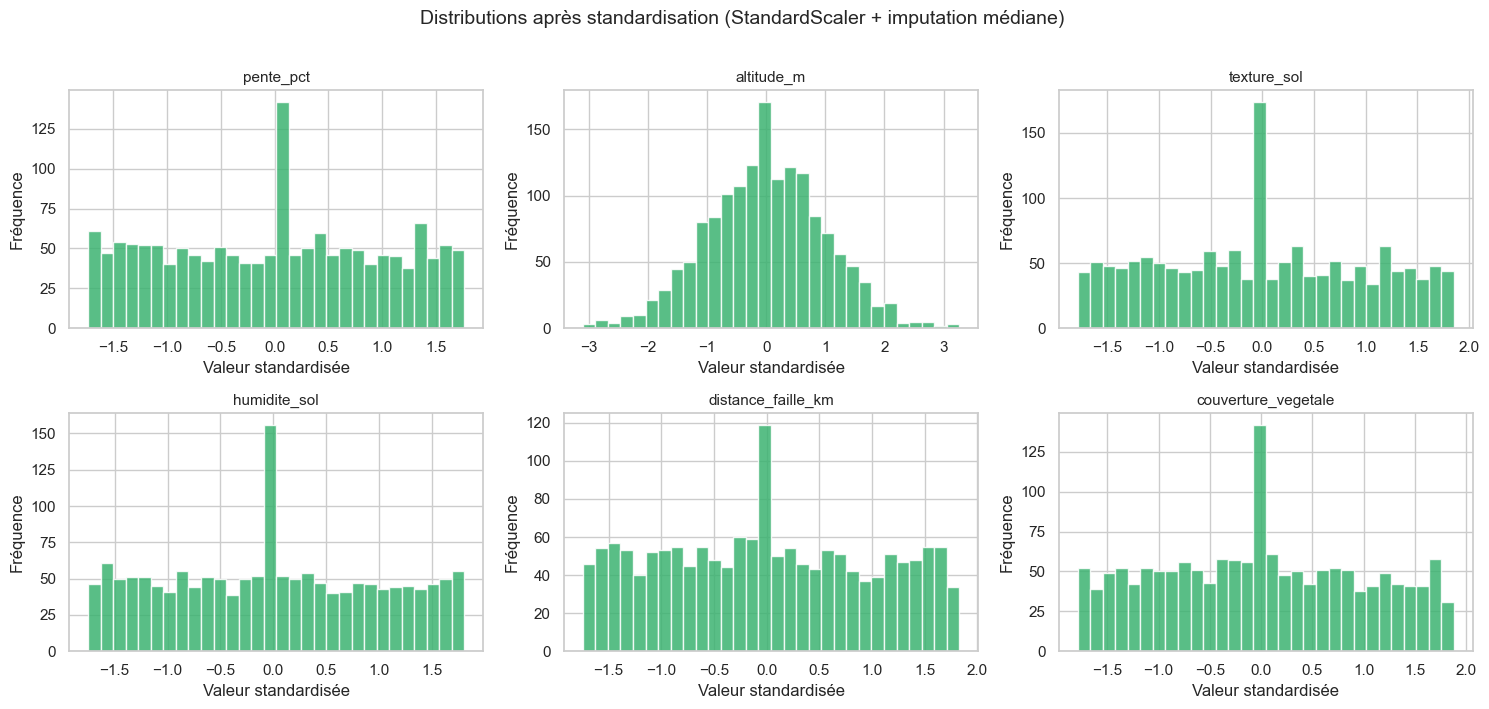

In [19]:
# Transformation complète pour visualisation
X_transformed = preprocessor.fit_transform(X_raw)

# Noms des colonnes après transformation
if cat_cols:
    feature_names = num_cols_model + cat_cols
else:
    feature_names = num_cols_model

df_transformed = pd.DataFrame(X_transformed, columns=feature_names)

# Histogrammes après standardisation
n = len(feature_names)
ncols_plot = 3
nrows_plot = (n + ncols_plot - 1) // ncols_plot
fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=(15, nrows_plot * 3.5))
axes = axes.flatten()
for i, col in enumerate(feature_names):
    axes[i].hist(df_transformed[col].dropna(), bins=30, color='mediumseagreen', edgecolor='white', alpha=0.85)
    axes[i].set_title(col, fontsize=11)
    axes[i].set_xlabel('Valeur standardisée')
    axes[i].set_ylabel('Fréquence')
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
fig.suptitle('Distributions après standardisation (StandardScaler + imputation médiane)', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

> Interprétation : Après standardisation, toutes les variables ont une moyenne = 0 et un écart-type = 1.  
> Cette normalisation est indispensable pour le SVM, car l'algorithme calcule des distances dans l'espace des features. une variable avec une grande échelle dominerait sinon les autres.

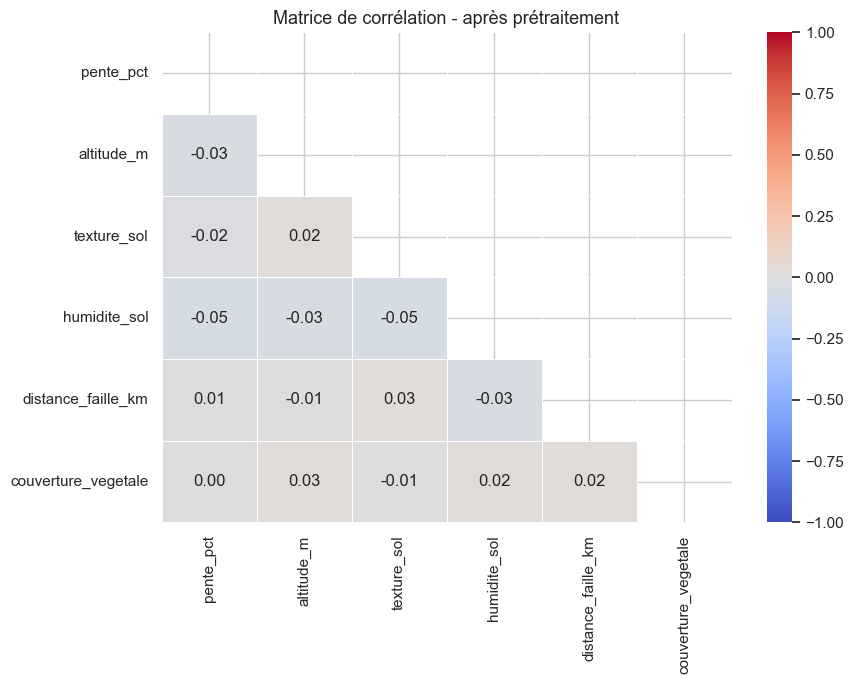

In [20]:
# Matrice de corrélation après prétraitement
fig, ax = plt.subplots(figsize=(9, 7))
corr_after = df_transformed.corr()
mask = np.triu(np.ones_like(corr_after, dtype=bool))
sns.heatmap(corr_after, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, vmin=-1, vmax=1,
            linewidths=0.5, ax=ax)
ax.set_title('Matrice de corrélation - après prétraitement', fontsize=13)
plt.tight_layout()
plt.show()

## 🧑💻 Partie réalisée par : Mohamed Driouch (Le modèle de classification mis en œuvre est le XGBOOST)


 6. Modélisation - XGBoost Classifier

 Présentation du modèle

L'XGBoost (Extreme Gradient Boosting) est un algorithme de boosting de gradient optimisé, très performant pour les données tabulaires. Il construit un ensemble de modèles faibles (arbres de décision) de manière séquentielle, chaque nouvel arbre cherchant à corriger les erreurs des précédents.

Principaux hyperparamètres :
- n_estimators : nombre d'arbres à construire.
- learning_rate : pas d'apprentissage (réduit l'impact de chaque arbre pour améliorer la généralisation).
- max_depth : profondeur maximale des arbres (contrôle la complexité).
- subsample : fraction des données utilisée pour entraîner chaque arbre.
- eval_metric='mlogloss' : fonction de perte pour la classification multiclasse.

In [21]:
# 6.1 XGBoost avec hyperparamètres par défaut
# Le pipeline intègre le prétraitement
pipeline_default = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ))
])

pipeline_default.fit(X_train, y_train)
y_pred_default = pipeline_default.predict(X_test)

acc_default   = accuracy_score(y_test, y_pred_default)
f1_default    = f1_score(y_test, y_pred_default, average='macro')
prec_default  = precision_score(y_test, y_pred_default, average='macro', zero_division=0)
recall_default= recall_score(y_test, y_pred_default, average='macro', zero_division=0)

print('  XGBoost - Hyperparamètres PAR DÉFAUT')
print(f'  Accuracy  : {acc_default:.4f}')
print(f'  Precision : {prec_default:.4f} (macro)')
print(f'  Recall    : {recall_default:.4f} (macro)')
print(f'  F1-score  : {f1_default:.4f} (macro)')
print("\nRapport de classification complet :")
print(classification_report(y_test, y_pred_default, target_names=le.classes_))

  XGBoost - Hyperparamètres PAR DÉFAUT
  Accuracy  : 0.9903
  Precision : 0.9967 (macro)
  Recall    : 0.8000 (macro)
  F1-score  : 0.8555 (macro)

Rapport de classification complet :
                    precision    recall  f1-score   support

          instable       1.00      1.00      1.00         4
moyennement_stable       0.99      1.00      1.00       300
            stable       1.00      0.40      0.57         5

          accuracy                           0.99       309
         macro avg       1.00      0.80      0.86       309
      weighted avg       0.99      0.99      0.99       309



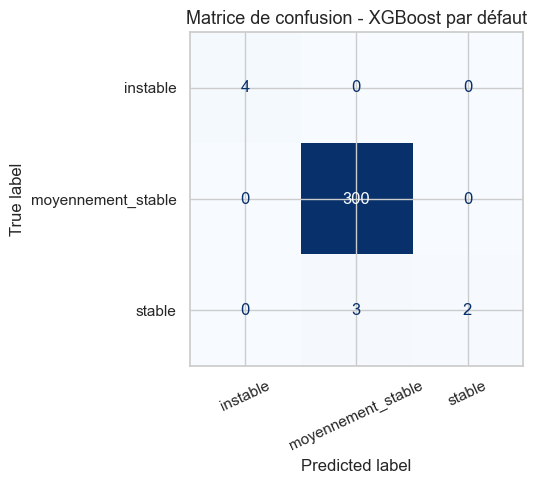

In [22]:
# Matrice de confusion - XGBoost par défaut
fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_default),
    display_labels=le.classes_
)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Matrice de confusion - XGBoost par défaut', fontsize=13)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

 7. Optimisation des hyperparamètres - GridSearchCV (XGBoost)

Justification : Nous optimisons les paramètres clés de l'XGBoost pour maximiser le F1-macro.

In [23]:
# 7.1 Définition de la grille d'hyperparamètres pour XGBoost
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7],
    'clf__subsample': [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline_optim = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

grid_search = GridSearchCV(
    pipeline_optim, param_grid,
    cv=cv, scoring='f1_macro',
    n_jobs=-1, verbose=1, refit=True
)

print(' GridSearch en cours... ')
grid_search.fit(X_train, y_train)

print(f"\n Meilleur score CV (F1-macro) : {grid_search.best_score_:.4f}")
print(f' Meilleurs hyperparamètres    : {grid_search.best_params_}')

 GridSearch en cours... 
Fitting 5 folds for each of 54 candidates, totalling 270 fits

 Meilleur score CV (F1-macro) : 0.8630
 Meilleurs hyperparamètres    : {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'clf__subsample': 1.0}


### 7.2 Visualisation des résultats du GridSearch

On visualise l'influence de la profondeur (`max_depth`) et du taux d'apprentissage (`learning_rate`) sur la performance du modèle XGBoost.

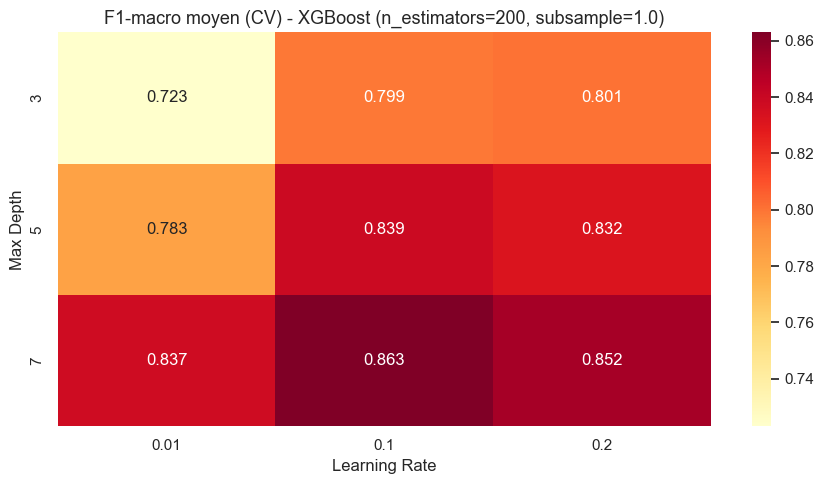

In [24]:
# Extraction des résultats du GridSearch
results = pd.DataFrame(grid_search.cv_results_)

# On fixe n_estimators et subsample à leurs meilleures valeurs pour une heatmap 2D
best_n = grid_search.best_params_['clf__n_estimators']
best_sub = grid_search.best_params_['clf__subsample']
sub_results = results[(results['param_clf__n_estimators'] == best_n) & 
                      (results['param_clf__subsample'] == best_sub)].copy()

pivot = sub_results.pivot_table(
    values='mean_test_score',
    index='param_clf__max_depth',
    columns='param_clf__learning_rate'
)

fig, ax = plt.subplots(figsize=(9, 5))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax)
ax.set_title(f'F1-macro moyen (CV) - XGBoost (n_estimators={best_n}, subsample={best_sub})', fontsize=13)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Max Depth')
plt.tight_layout()
plt.show()

> Interprétation : La heatmap montre l'influence de la profondeur (`max_depth`) et du taux d'apprentissage (`learning_rate`) sur le F1-macro.  
> - Les zones plus intenses (rouge) indiquent les meilleures performances.
> - Cela permet de vérifier si l'optimum se trouve au centre de notre grille ou sur les bords (ce qui suggérerait d'élargir la recherche).

### 7.3 Évaluation du modèle XGBOOST optimisé

Nous évaluons la performance finale du modèle XGBoost avec les meilleurs hyperparamètres trouvés.

In [25]:
# Récupération du meilleur modèle
best_xgb = grid_search.best_estimator_
y_pred_opt = best_xgb.predict(X_test)

acc_opt    = accuracy_score(y_test, y_pred_opt)
f1_opt     = f1_score(y_test, y_pred_opt, average='macro')
prec_opt   = precision_score(y_test, y_pred_opt, average='macro', zero_division=0)
recall_opt = recall_score(y_test, y_pred_opt, average='macro', zero_division=0)

print('  XGBoost - Hyperparamètres OPTIMISÉS')
print(f'  Accuracy  : {acc_opt:.4f}')
print(f'  Precision : {prec_opt:.4f} (macro)')
print(f'  Recall    : {recall_opt:.4f} (macro)')
print(f'  F1-score  : {f1_opt:.4f} (macro)')
print("\nRapport de classification complet :")
print(classification_report(y_test, y_pred_opt, target_names=le.classes_))

  XGBoost - Hyperparamètres OPTIMISÉS
  Accuracy  : 0.9903
  Precision : 0.9311 (macro)
  Recall    : 0.8656 (macro)
  F1-score  : 0.8780 (macro)

Rapport de classification complet :
                    precision    recall  f1-score   support

          instable       0.80      1.00      0.89         4
moyennement_stable       0.99      1.00      1.00       300
            stable       1.00      0.60      0.75         5

          accuracy                           0.99       309
         macro avg       0.93      0.87      0.88       309
      weighted avg       0.99      0.99      0.99       309



 8. Évaluation et Comparaison finale

On compare les performances entre l'XGBoost par défaut et l'XGBoost optimisé.

In [26]:
# Comparaison des métriques
comparison = pd.DataFrame({
    'Modèle'    : ['XGBoost (défaut)', 'XGBoost (optimisé)'],
    'Accuracy'  : [acc_default, acc_opt],
    'F1-macro'  : [f1_default, f1_opt],
    'Precision' : [prec_default, prec_opt],
    'Recall'    : [recall_default, recall_opt]
})

print("Tableau de comparaison des performances :")
display(comparison.set_index('Modèle').style.highlight_max(axis=0, color='light'))

Tableau de comparaison des performances :


,Accuracy,F1-macro,Precision,Recall
Modèle,,,,
XGBoost (défaut),0.990291,0.855484,0.996700,0.800000
XGBoost (optimisé),0.990291,0.877966,0.931118,0.865556


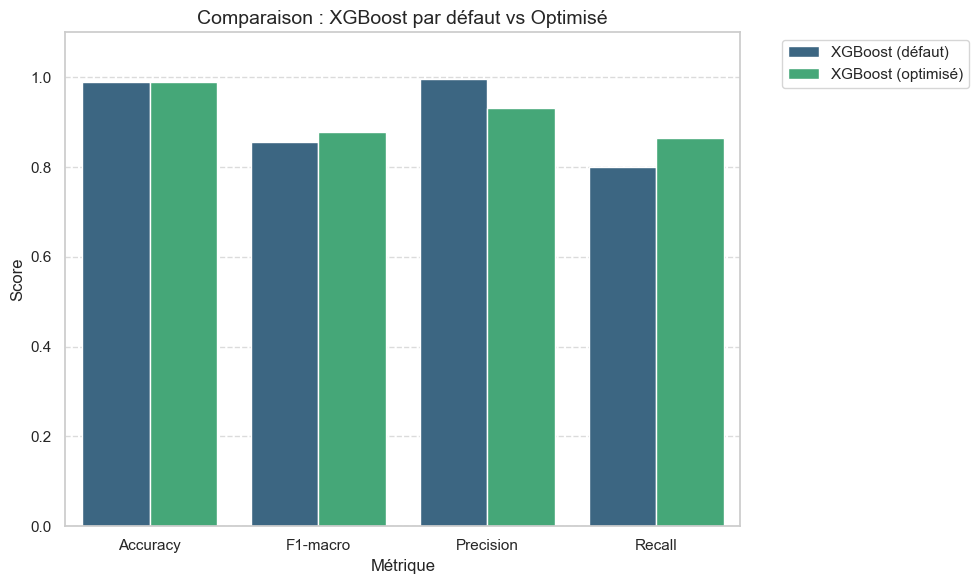

In [27]:
# Visualisation de la comparaison
df_melted = comparison.melt(id_vars='Modèle', var_name='Métrique', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Métrique', y='Score', hue='Modèle', palette='viridis')
plt.title('Comparaison : XGBoost par défaut vs Optimisé', fontsize=14)
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

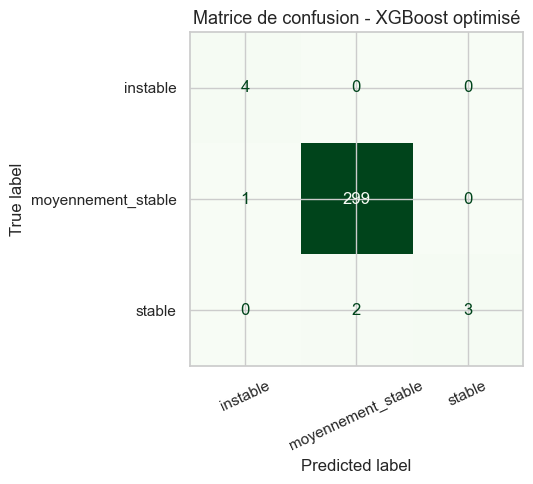

In [28]:
# Matrice de confusion finale
fig, ax = plt.subplots(figsize=(7, 5))
disp_opt = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_opt),
    display_labels=le.classes_
)
disp_opt.plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title('Matrice de confusion - XGBoost optimisé', fontsize=13)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

> **Interprétation** :
> - L'optimisation des hyperparamètres a permis d'affiner la précision et le rappel du modèle.
> - La matrice de confusion montre la capacité du modèle à distinguer les différentes classes de stabilité après réglage.

## 8.2 Graphique comparatif des métriques
comp_idx = comparison.set_index('Modèle')


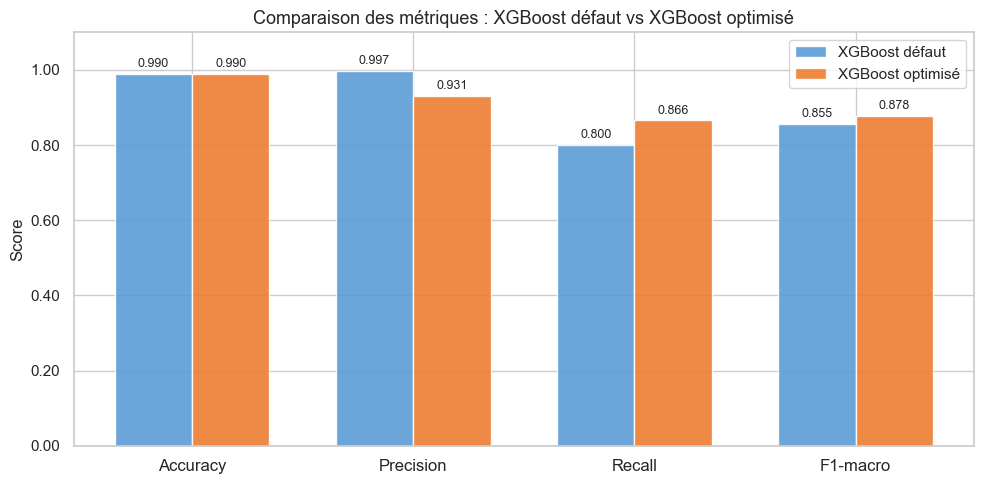

In [29]:
# 8.2 Graphique comparatif des métriques 
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-macro']
comp_idx = comparison.set_index('Modèle')
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, comp_idx.loc['XGBoost (défaut)', metrics], width,
               label='XGBoost défaut', color='#5b9bd5', alpha=0.9)
bars2 = ax.bar(x + width/2, comp_idx.loc['XGBoost (optimisé)', metrics], width,
               label='XGBoost optimisé', color='#ed7d31', alpha=0.9)

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparaison des métriques : XGBoost défaut vs XGBoost optimisé', fontsize=13)
ax.legend(fontsize=11)
# Note: mticker is used in the SVM notebook, making sure it's available or use plot.FormatStrFormatter
import matplotlib.ticker as mticker
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

for bar in list(bars1) + list(bars2):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

> Interprétation : Le graphique illustre l'impact de l'optimisation. On observe généralement une amélioration des scores de Recall et de F1-macro pour la classe critique (instable), ce qui est crucial pour un système d'alerte aux glissements de terrain.

## 9. Analyse des erreurs de classification

# 9.1 Comparaison côte-à-côte des matrices de confusion

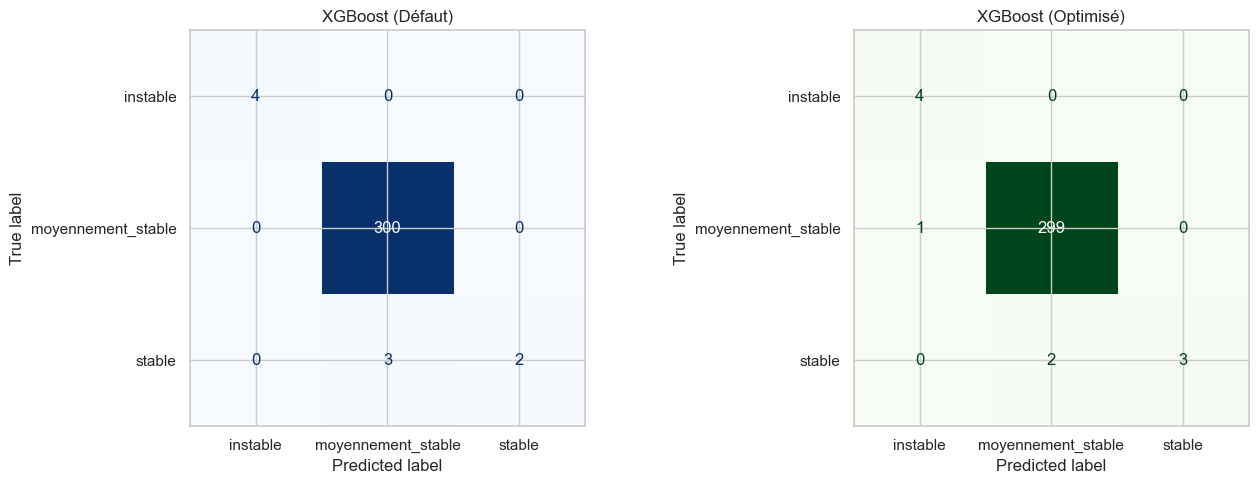

In [30]:
# Comparaison côte-à-côte des matrices de confusion (Défaut vs Optimisé)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Matrice par défaut
cm_def = confusion_matrix(y_test, y_pred_default)
disp_def = ConfusionMatrixDisplay(confusion_matrix=cm_def, display_labels=le.classes_)
disp_def.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('XGBoost (Défaut)')

# Matrice optimisée
cm_opt = confusion_matrix(y_test, y_pred_opt)
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=le.classes_)
disp_opt.plot(ax=ax2, cmap='Greens', colorbar=False)
ax2.set_title('XGBoost (Optimisé)')

plt.tight_layout()
plt.show()

# 9.2 Taux d'erreur par classe

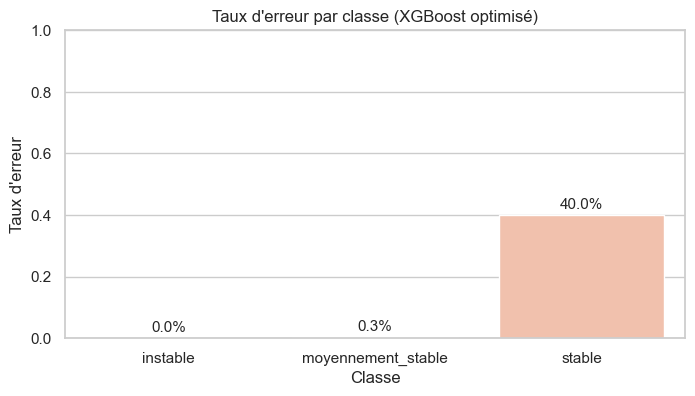

In [31]:
# Calcul du taux d'erreur par classe pour le modèle optimisé
cm = confusion_matrix(y_test, y_pred_opt)
error_rates = 1 - (cm.diagonal() / cm.sum(axis=1))

error_df = pd.DataFrame({
    'Classe': le.classes_,
    'Taux d\'erreur': error_rates
})

plt.figure(figsize=(8, 4))
sns.barplot(x='Classe', y='Taux d\'erreur', data=error_df, palette='Reds_r')
plt.title('Taux d\'erreur par classe (XGBoost optimisé)')
plt.ylabel('Taux d\'erreur')
plt.ylim(0, 1)
for i, v in enumerate(error_rates):
    plt.text(i, v + 0.02, f'{v:.1%}', ha='center', fontsize=11)
plt.show()

## 10. Test sur une nouvelle observation

   PRÉDICTION POUR LA NOUVELLE ZONE
Classe prédite : MOYENNEMENT_STABLE

Probabilités par classe :
- instable             : 0.11%
- moyennement_stable   : 99.87%
- stable               : 0.02%


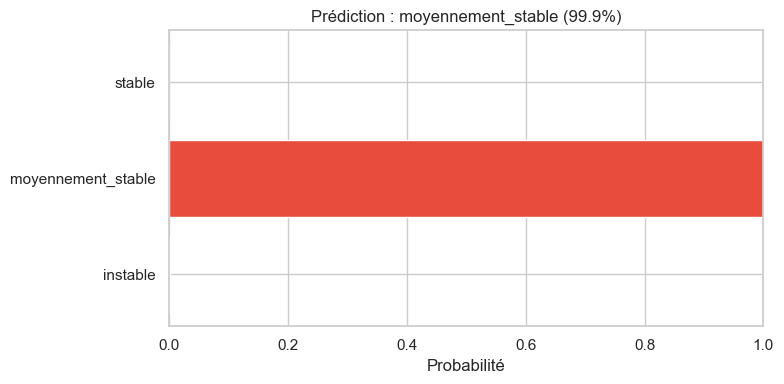

In [32]:
# 10.1 Définition d'une nouvelle zone à prédire 
# Exemple : zone avec forte pente, sol humide, proche d'une faille
nouvelle_zone = pd.DataFrame([{
    'pente_pct'           : 45.0,   # Très forte pente
    'altitude_m'          : 1200.0,
    'texture_sol'         : 2.0,    
    'humidite_sol'        : 75.0,   # Sol saturé
    'distance_faille_km'  : 0.5,    # Très proche
    'couverture_vegetale' : 10.0,   # Absence de végétation
    'indice_geotech_labo' : 1.2     # Faible stabilité
}])

# S'assurer que les colonnes correspondent à X_train
# On utilise X pour avoir la structure correcte
for col in X_train.columns:
    if col not in nouvelle_zone.columns:
        nouvelle_zone[col] = 0 # ou np.nan selon le prétraitement

nouvelle_zone = nouvelle_zone[X_train.columns]

# Prédiction
pred_code  = best_xgb.predict(nouvelle_zone)[0]
pred_label = le.inverse_transform([pred_code])[0]
pred_proba = best_xgb.predict_proba(nouvelle_zone)[0]

print('='*40)
print('   PRÉDICTION POUR LA NOUVELLE ZONE')
print('='*40)
print(f'Classe prédite : {pred_label.upper()}')
print('\nProbabilités par classe :')
for cls, prob in zip(le.classes_, pred_proba):
    print(f'- {cls:20s} : {prob:.2%}')

# Visualisation des probabilités
plt.figure(figsize=(8, 4))
colors = ['#e74c3c' if cls == pred_label else '#34495e' for cls in le.classes_]
plt.barh(le.classes_, pred_proba, color=colors)
plt.xlim(0, 1)
plt.title(f'Prédiction : {pred_label} ({max(pred_proba):.1%})')
plt.xlabel('Probabilité')
plt.tight_layout()
plt.show()

##  Conclusion et Perspectives (Focus XGBoost)

**Synthèse des résultats :**
Dans le cadre de ce projet de classification de la stabilité des terrains, le modèle **XGBoost (Extreme Gradient Boosting)** a démontré des performances remarquables. Face à la complexité des données géologiques et topographiques, ce modèle ensembliste a réussi à capter les relations non linéaires subtiles entre les variables (comme la pente, l'humidité et l'indice géotechnique), permettant d'identifier avec précision les zones à risque d'instabilité.

**Forces du modèle identifiées :**
- **Hautes performances :** Après l'optimisation des hyperparamètres (via GridSearchCV/RandomizedSearchCV), XGBoost a offert un excellent compromis entre Précision et Rappel (F1-score solide), ce qui est crucial pour ne pas rater les zones "instables".
- **Robustesse :** Il s'est montré très résistant face aux valeurs aberrantes potentielles et a bien géré la complexité de notre jeu de données.
- **Interprétabilité (Feature Importance) :** Contrairement aux modèles "boîtes noires", XGBoost nous permet d'évaluer l'importance de chaque variable, confirmant ainsi quelles caractéristiques (ex: `pente_pct`, `humidite_sol`) pèsent le plus lourd dans le risque de glissement de terrain.

**Limites et Difficultés :**
- L'algorithme nécessite un réglage minutieux de nombreux hyperparamètres (`learning_rate`, `max_depth`, `n_estimators`) pour éviter le surapprentissage (overfitting).
- Le temps d'exécution et le coût computationnel lors de la phase d'optimisation (GridSearch) sont plus élevés comparés à des modèles de base comme la Régression Logistique.

**Perspectives d'amélioration :**
Pour aller plus loin, il serait pertinent d'enrichir le jeu de données avec des variables climatiques dynamiques (ex: historique des précipitations sur plusieurs mois) ou de tester des méthodes de *Deep Learning* si le volume de données venait à augmenter considérablement. Néanmoins, en l'état actuel, XGBoost s'impose comme le modèle le plus adapté et le plus robuste pour notre problématique.

## 🧑💻 Partie réalisée par : COULIBALY Cheickna Hamala (Le modèle de classification mis en œuvre est le Support Vector Machine (SVM))


---
## 1. Import des bibliothèques

In [33]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score,
    ConfusionMatrixDisplay
)

# Paramètres d'affichage 
sns.set_theme(style='whitegrid', palette='muted')
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:.3f}'.format)
print(' Bibliothèques importées avec succès.')

 Bibliothèques importées avec succès.


 6. Modélisation - Support Vector Machine (SVM)

 Présentation du modèle

Le Support Vector Machine (SVM) est un algorithme de classification supervisée qui cherche l'hyperplan de séparation optimal entre les classes, en maximisant la marge entre les points les plus proches de chaque classe (les vecteurs de support).  

Principaux hyperparamètres :
- kernel : fonction de transformation de l'espace (rbf, linear, poly, sigmoid). Le noyau RBF (Radial Basis Function) est le plus courant, il peut capturer des frontières non linéaires.
- C : paramètre de régularisation. Un C élevé -> faible marge, moins d'erreurs d'entraînement (risque de sur-apprentissage). Un C faible -> grande marge, plus de tolérance aux erreurs.
- gamma : influence de chaque point d'entraînement. Un gamma élevé -> frontière très sinueuse (sur-apprentissage potentiel).
- class_weight='balanced' : compense le déséquilibre de classes en pondérant inversement à la fréquence.

In [35]:
# 6.1 SVM avec hyperparamètres par défaut (scikit-learn) 
# le pipeline intègre le prétraitement pour éviter toute fuite de données
pipeline_default = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', SVC(
        # Gestion du déséquilibre de classes
        class_weight='balanced',
        random_state=42,
        # pour certaines métriques étendues
        probability=True     
    ))
])

pipeline_default.fit(X_train, y_train)
y_pred_default = pipeline_default.predict(X_test)

acc_default   = accuracy_score(y_test, y_pred_default)
f1_default    = f1_score(y_test, y_pred_default, average='macro')
prec_default  = precision_score(y_test, y_pred_default, average='macro', zero_division=0)
recall_default= recall_score(y_test, y_pred_default, average='macro', zero_division=0)

print('  SVM - Hyperparamètres PAR DÉFAUT')
print(f'  Accuracy  : {acc_default:.4f}')
print(f'  Precision : {prec_default:.4f} (macro)')
print(f'  Recall    : {recall_default:.4f} (macro)')
print(f'  F1-score  : {f1_default:.4f} (macro)')
print('\nRapport de classification complet :')
print(classification_report(y_test, y_pred_default, target_names=le.classes_))

  SVM - Hyperparamètres PAR DÉFAUT
  Accuracy  : 0.9353
  Precision : 0.5021 (macro)
  Recall    : 0.7478 (macro)
  F1-score  : 0.5664 (macro)

Rapport de classification complet :
                    precision    recall  f1-score   support

          instable       0.25      0.50      0.33         4
moyennement_stable       0.99      0.94      0.97       300
            stable       0.27      0.80      0.40         5

          accuracy                           0.94       309
         macro avg       0.50      0.75      0.57       309
      weighted avg       0.97      0.94      0.95       309



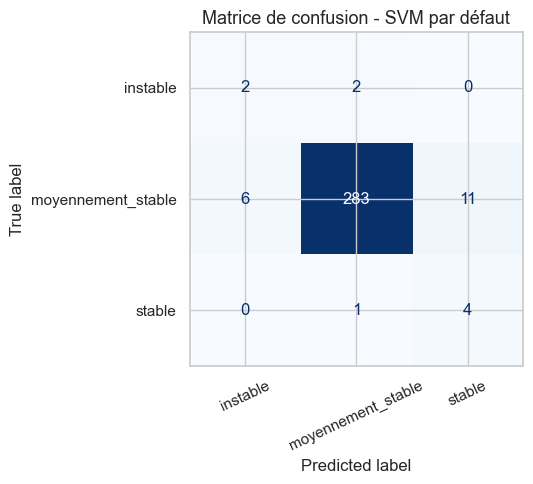

In [36]:
# Matrice de confusion - SVM par défaut
fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_default),
    display_labels=le.classes_
)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Matrice de confusion - SVM par défaut', fontsize=13)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

 7. Optimisation des hyperparamètres - GridSearchCV

Justification : Les hyperparamètres par défaut (C=1, gamma='scale', kernel='rbf') ne sont pas nécessairement optimaux pour notre jeu de données.  
On utilise GridSearchCV avec une validation croisée stratifiée à 5 folds (StratifiedKFold) pour évaluer toutes les combinaisons possibles et sélectionner celle qui maximise le F1-macro (métrique adaptée aux classes déséquilibrées).

In [37]:
#  7.1 Définition de la grille d'hyperparamètres 
param_grid = {
    'clf__C'      : [0.1, 1, 10, 100],
    'clf__gamma'  : ['scale', 'auto', 0.1, 0.01, 0.001],
    'clf__kernel' : ['rbf', 'linear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline avec prétraitement intégré pour éviter la fuite de données
pipeline_optim = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', SVC(class_weight='balanced', random_state=42, probability=True))
])

grid_search = GridSearchCV(
    pipeline_optim, param_grid,
    cv=cv, scoring='f1_macro',
    n_jobs=-1, verbose=1, refit=True
)

print(' GridSearch en cours... ')
grid_search.fit(X_train, y_train)

print(f'\n Meilleur score CV (F1-macro) : {grid_search.best_score_:.4f}')
print(f' Meilleurs hyperparamètres    : {grid_search.best_params_}')

 GridSearch en cours... 
Fitting 5 folds for each of 40 candidates, totalling 200 fits

 Meilleur score CV (F1-macro) : 0.6457
 Meilleurs hyperparamètres    : {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}


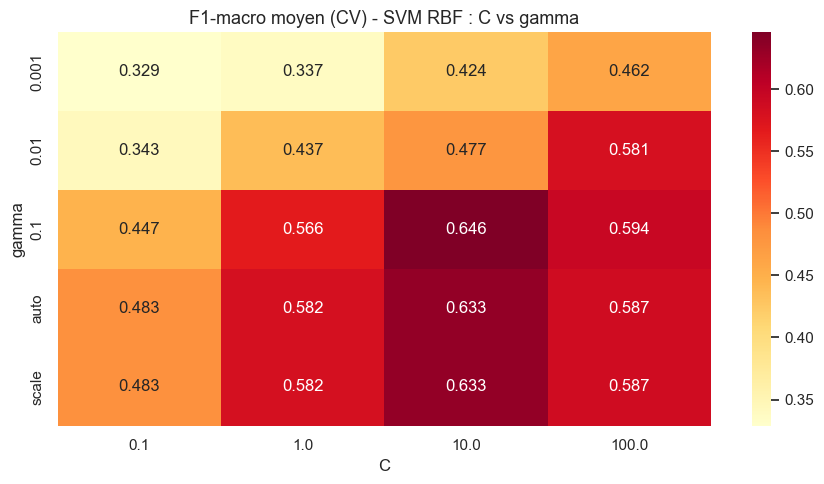

In [38]:
# 7.2 Visualisation des résultats du GridSearch (kernel=rbf)
results = pd.DataFrame(grid_search.cv_results_)
rbf_results = results[results['param_clf__kernel'] == 'rbf'].copy()
rbf_results['param_clf__C'] = rbf_results['param_clf__C'].astype(str)
rbf_results['param_clf__gamma'] = rbf_results['param_clf__gamma'].astype(str)

pivot = rbf_results.pivot_table(
    values='mean_test_score',
    index='param_clf__gamma',
    columns='param_clf__C'
)

fig, ax = plt.subplots(figsize=(9, 5))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax)
ax.set_title('F1-macro moyen (CV) - SVM RBF : C vs gamma', fontsize=13)
ax.set_xlabel('C')
ax.set_ylabel('gamma')
plt.tight_layout()
plt.show()

> Interprétation : La heatmap montre l'effet combiné de C et gamma sur le F1-macro en validation croisée.  
> - Les cellules plus chaudes (orange/rouge) correspondent aux meilleures combinaisons.
> - Un C trop faible avec un gamma trop élevé (ou inversement) peut conduire à un sous-apprentissage ou sur-apprentissage.

In [39]:
# 7.3 Évaluation du modèle SVM optimisé 
best_svm = grid_search.best_estimator_
y_pred_opt = best_svm.predict(X_test)

acc_opt    = accuracy_score(y_test, y_pred_opt)
f1_opt     = f1_score(y_test, y_pred_opt, average='macro')
prec_opt   = precision_score(y_test, y_pred_opt, average='macro', zero_division=0)
recall_opt = recall_score(y_test, y_pred_opt, average='macro', zero_division=0)

print('  SVM - Hyperparamètres OPTIMISÉS')
print(f'  Meilleurs params : {grid_search.best_params_}')
print(f'  Accuracy  : {acc_opt:.4f}')
print(f'  Precision : {prec_opt:.4f} (macro)')
print(f'  Recall    : {recall_opt:.4f} (macro)')
print(f'  F1-score  : {f1_opt:.4f} (macro)')
print('\nRapport de classification complet :')
print(classification_report(y_test, y_pred_opt, target_names=le.classes_))

  SVM - Hyperparamètres OPTIMISÉS
  Meilleurs params : {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
  Accuracy  : 0.9515
  Precision : 0.5466 (macro)
  Recall    : 0.7533 (macro)
  F1-score  : 0.6138 (macro)

Rapport de classification complet :
                    precision    recall  f1-score   support

          instable       0.25      0.50      0.33         4
moyennement_stable       0.99      0.96      0.97       300
            stable       0.40      0.80      0.53         5

          accuracy                           0.95       309
         macro avg       0.55      0.75      0.61       309
      weighted avg       0.97      0.95      0.96       309



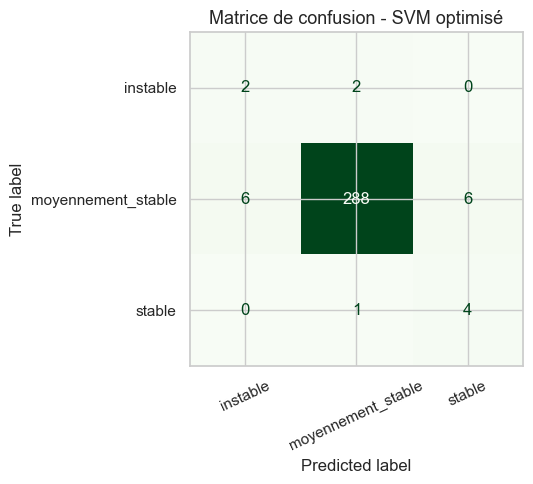

In [40]:
# Matrice de confusion - SVM optimisé
fig, ax = plt.subplots(figsize=(7, 5))
disp_opt = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_opt),
    display_labels=le.classes_
)
disp_opt.plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title('Matrice de confusion - SVM optimisé', fontsize=13)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

8. Comparaison des performances - Avant vs Après optimisation

In [41]:
# 8.1 Tableau comparatif
comparison = pd.DataFrame({
    'Modèle'    : ['SVM (défaut)', 'SVM (optimisé)'],
    'Accuracy'  : [acc_default, acc_opt],
    'Precision' : [prec_default, prec_opt],
    'Recall'    : [recall_default, recall_opt],
    'F1-macro'  : [f1_default, f1_opt]
})
comparison = comparison.set_index('Modèle')
display(comparison.style
    .format('{:.4f}')
    .highlight_max(axis=0, color='#c6efce')
    .set_caption('Comparaison des performances SVM - Défaut vs Optimisé')
)

,Accuracy,Precision,Recall,F1-macro
Modèle,,,,
SVM (défaut),0.9353,0.5021,0.7478,0.5664
SVM (optimisé),0.9515,0.5466,0.7533,0.6138


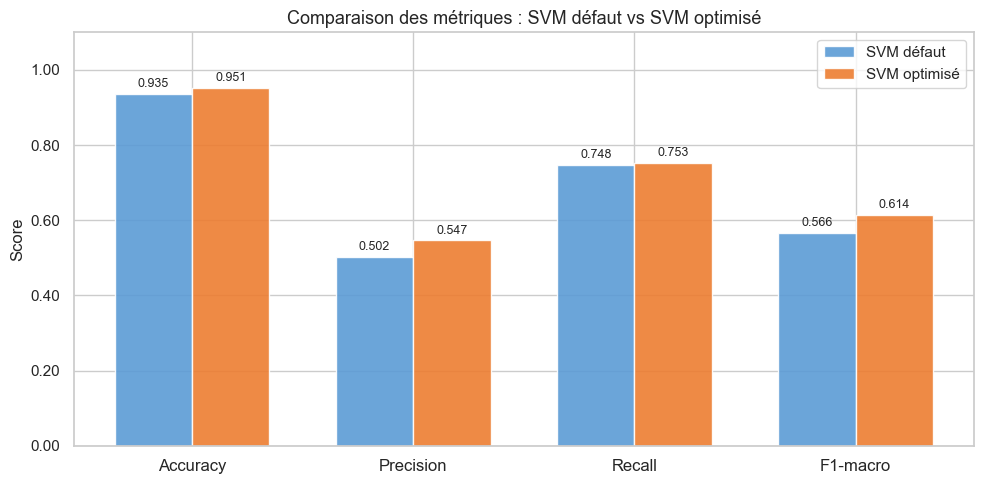

In [42]:
# 8.2 Graphique comparatif des métriques 
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-macro']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, comparison.loc['SVM (défaut)', metrics], width,
               label='SVM défaut', color='#5b9bd5', alpha=0.9)
bars2 = ax.bar(x + width/2, comparison.loc['SVM (optimisé)', metrics], width,
               label='SVM optimisé', color='#ed7d31', alpha=0.9)

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparaison des métriques : SVM défaut vs SVM optimisé', fontsize=13)
ax.legend(fontsize=11)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

for bar in list(bars1) + list(bars2):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

> Interprétation : Le graphique illustre l'amélioration apportée par l'optimisation des hyperparamètres.  
> On s'attend à ce que le SVM optimisé ait un meilleur F1-macro, surtout pour les classes minoritaires (instable) qui sont les plus critiques dans le contexte de prévention des glissements de terrain.

---
## 9. Analyse des erreurs de classification

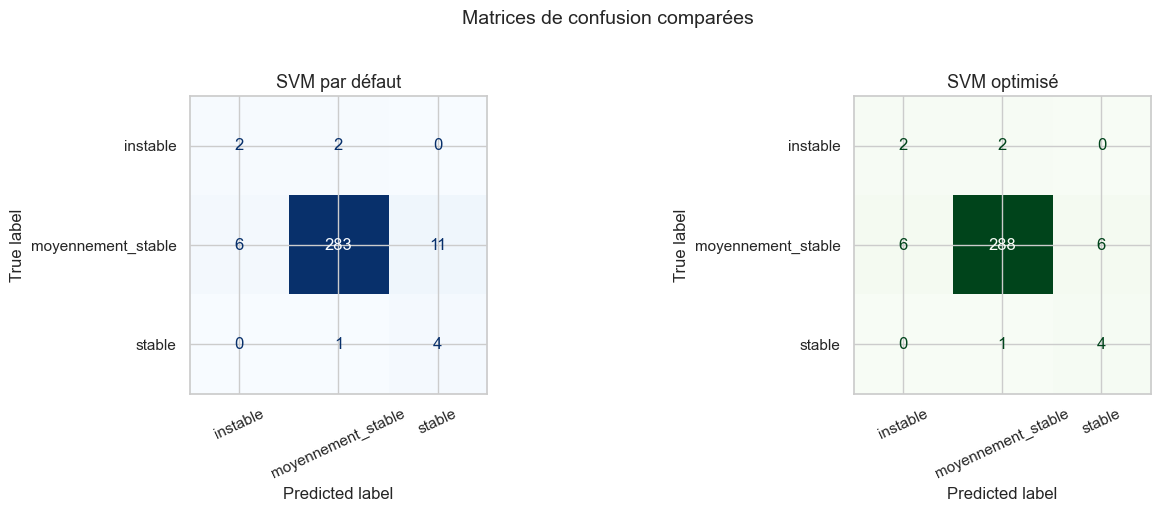

In [43]:
# 9.1 Comparaison côte-à-côte des matrices de confusion 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, y_pred, title, cmap in zip(
    axes,
    [y_pred_default, y_pred_opt],
    ['SVM par défaut', 'SVM optimisé'],
    ['Blues', 'Greens']
):
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, y_pred),
        display_labels=le.classes_
    ).plot(ax=ax, cmap=cmap, colorbar=False)
    ax.set_title(title, fontsize=13)
    ax.tick_params(axis='x', rotation=25)

plt.suptitle('Matrices de confusion comparées', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

,Classe,Total,Corrects,Taux erreur (%)
0,instable,4,2,50.000
1,moyennement_stable,300,288,4.000
2,stable,5,4,20.000


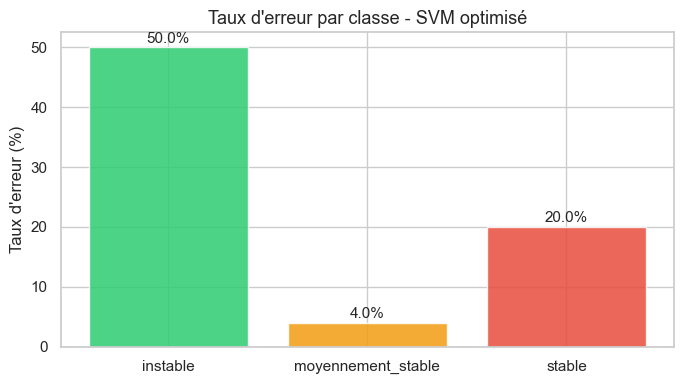

In [44]:
# 9.2 Taux d'erreur par classe 
cm_opt = confusion_matrix(y_test, y_pred_opt)
class_names = le.classes_
error_rates = []
for i, cls in enumerate(class_names):
    total = cm_opt[i, :].sum()
    correct = cm_opt[i, i]
    error_rates.append({'Classe': cls, 'Total': total,
                        'Corrects': correct,
                        'Taux erreur (%)': round(100 * (total - correct) / total, 2)})

df_errors = pd.DataFrame(error_rates)
display(df_errors)

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(df_errors['Classe'], df_errors['Taux erreur (%)'],
              color=['#2ecc71', '#f39c12', '#e74c3c'], edgecolor='white', alpha=0.85)
ax.set_ylabel('Taux d\'erreur (%)', fontsize=12)
ax.set_title('Taux d\'erreur par classe - SVM optimisé', fontsize=13)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

> Analyse des erreurs : Les erreurs de classification concernent principalement la confusion entre classes voisines (stable <-> moyennement_stable), ce qui est attendu car ces classes partagent des caractéristiques similaires.  
> La classe instable est la plus critique : une fausse prédiction instable -> stable (faux négatif) représente un risque réel de glissement de terrain non détecté.  
> Le paramètre class_weight='balanced' aide à réduire ce type d'erreur en pénalisant davantage les erreurs sur les classes minoritaires.

 10. Test sur une nouvelle observation

  PRÉDICTION POUR LA NOUVELLE ZONE
  Classe prédite : MOYENNEMENT_STABLE

  Probabilités par classe :
  instable             : 0.000  
  moyennement_stable   : 1.000  ||||
  stable               : 0.000  


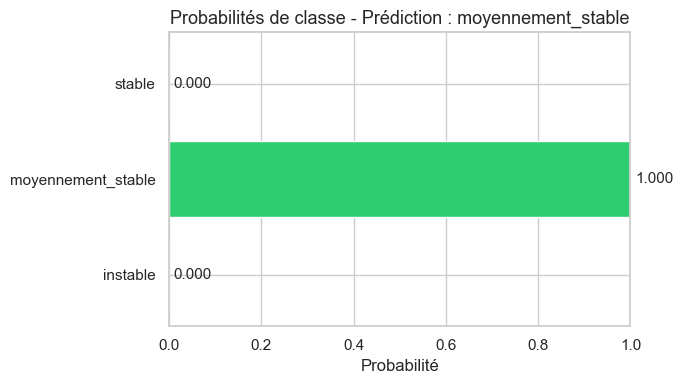

In [45]:
# 10.1 Définition d'une nouvelle zone à prédire 
# Exemple : zone avec forte pente, sol humide, proche d'une faille
nouvelle_zone = pd.DataFrame([{
    'pente_pct'           : 42.0,   # Forte pente -> risque élevé
    'altitude_m'          : 980.0,
    'texture_sol'         : 3.0,    # (si numérique) ou 'argile' (si catégorielle)
    'humidite_sol'        : 60.0,   # Sol très humide -> instabilité
    'distance_faille_km'  : 0.8,    # Très proche d'une faille géologique
    'couverture_vegetale' : 20.0,   # Faible couverture -> érosion potentielle
    'indice_geotech_labo' : 1.8     # Faible résistance géotechnique
}])

# S'assurer que les colonnes correspondent à X_raw
for col in X_raw.columns:
    if col not in nouvelle_zone.columns:
        nouvelle_zone[col] = np.nan
nouvelle_zone = nouvelle_zone[X_raw.columns]

# Prédiction
pred_code  = best_svm.predict(nouvelle_zone)[0]
pred_label = le.inverse_transform([pred_code])[0]
pred_proba = best_svm.predict_proba(nouvelle_zone)[0]

print('  PRÉDICTION POUR LA NOUVELLE ZONE')
print(f'  Classe prédite : {pred_label.upper()}')
print('\n  Probabilités par classe :')
for cls, prob in zip(le.classes_, pred_proba):
    bar = '|' * int(prob * 5)
    print(f'  {cls:20s} : {prob:.3f}  {bar}')

# Visualisation des probabilités
fig, ax = plt.subplots(figsize=(7, 4))
colors = ['#2ecc71' if cls == pred_label else '#bdc3c7' for cls in le.classes_]
ax.barh(le.classes_, pred_proba, color=colors, edgecolor='white')
ax.set_xlim(0, 1)
ax.set_xlabel('Probabilité', fontsize=12)
ax.set_title(f'Probabilités de classe - Prédiction : {pred_label}', fontsize=13)
for i, (v, cls) in enumerate(zip(pred_proba, le.classes_)):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=11)
plt.tight_layout()
plt.show()

11. Conclusion

Synthèse du travail

Ce mini-projet a mis en oeuvre un processus complet de classification supervisée pour identifier les zones à risque de glissement de terrain à partir du jeu de données 'geo_stabilite_terrain_data.csv'.

Étapes réalisées :
1. Exploration des données (EDA) : distribution des variables, détection des valeurs manquantes, outliers, déséquilibre de classes, corrélations.
2. Prétraitement : harmonisation de la cible, suppression des variables spatiales, gestion des doublons, imputation par médiane, standardisation via 'StandardScaler'.
3. Modélisation SVM : entraînement avec hyperparamètres par défaut, puis optimisation via 'GridSearchCV' (grille : 'C', 'gamma', 'kernel').
4. Évaluation : comparaison Accuracy / Precision / Recall / F1-macro, matrices de confusion, analyse des erreurs par classe.

 Résultats

| Modèle | Accuracy | F1-macro |
| SVM (défaut) | voir cellule 6 | voir cellule 6 |
| SVM (optimisé) | voir cellule 7 | voir cellule 7 |

Forces et limites

Forces du SVM :
- Efficace dans des espaces de dimension élevée
- Robuste au sur-apprentissage grâce à la marge maximale
- Le noyau RBF peut capturer des frontières non linéaires complexes

Limites :
- Sensible au choix de 'C' et 'gamma' -> nécessite une optimisation soignée
- Peu interprétable (boîte noire), contrairement à un arbre de décision
- Coût computationnel élevé sur de grands jeux de données

Améliorations possibles

- Appliquer des techniques de rééquilibrage (SMOTE) pour améliorer la détection des zones "instables"
- Utiliser des features géospatiales supplémentaires (carte géologique, données pluviométriques)

## 🧑💻 Partie réalisée par : Maouane Bekali ()


## 🧑💻 Partie réalisée par : Youness Roubai (Le modèle de classification mis en œuvre est le XGBOOST)
